<a href="https://colab.research.google.com/github/victoriaprestes/ifood-data-analyst-case/blob/main/iFood_Data_Analyst_Case_An_Exploratory_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise do dataset

#
Primeiro, irei buscar entender melhor os clientes, suas características pessoais e seus hábitos de compra

In [920]:
#Importando bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats.mstats import winsorize
from statsmodels.formula.api import logit, ols
from dateutil.relativedelta import relativedelta

In [921]:
project_data = pd.read_csv('project_data.csv')
# Para manter o original, vou criar uma cópia do dataframe
ifood_df = project_data.copy()
#Verificando meus dados
ifood_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

O dataframe possui 24 valores nulos, todos na coluna de salário

## Lidando com nulos e outliers


In [922]:
# Via de regra, se os nulos forem até 5% dos dados, podemos simplesmente deletá-los.
lim = len(ifood_df) * 0.05
to_drop = ifood_df.columns[(ifood_df.isna().sum() < lim) & (ifood_df.isna().sum() > 0)]
ifood_df.dropna(subset=to_drop, inplace=True)
ifood_df['Income'].isna().sum()

0

In [923]:
ifood_df['Income'].describe()

,Income
count,2216.000000
mean,52247.251354
std,25173.076661
min,1730.000000
25%,35303.000000
50%,51381.500000
75%,68522.000000
max,666666.000000


Aqui já encontro outro problema: os valores máximo e mínimos diferem muito do esperado, claramente outliers.
Consequentemente, usar a média está fora de questão, visto que ela é altamente influenciada por esses valores.



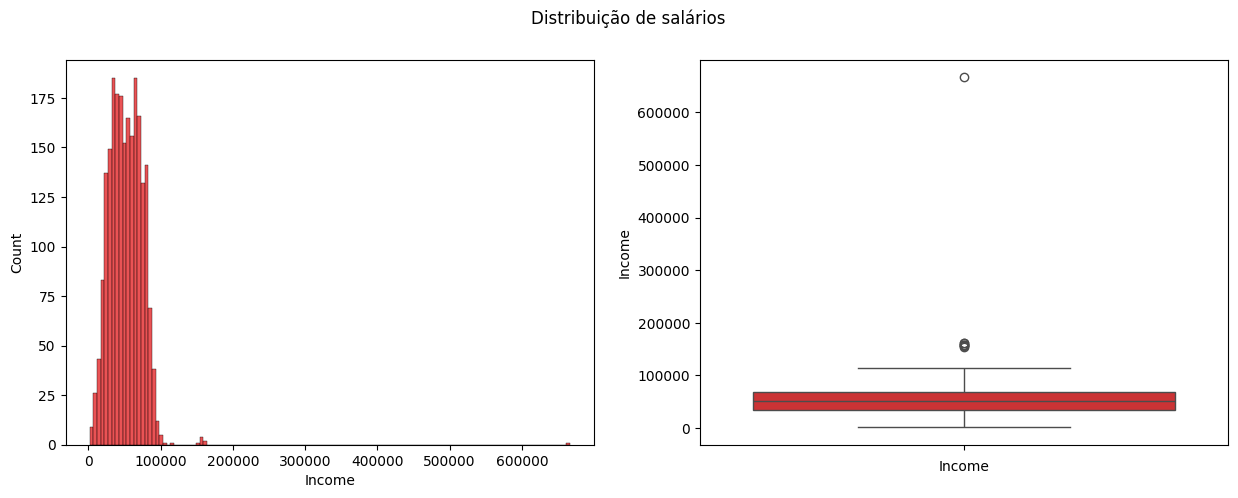

In [924]:
#Verificando a distribuição dos dados
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=ifood_df, x='Income',fill=True, ax=ax[0])
sns.boxplot(data=ifood_df['Income'],  ax=ax[1])
plt.xlabel('Income')
plt.suptitle('Distribuição de salários')
plt.show()

In [925]:
def upper_limits(df, var):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3-q1
    limit = 1.5 * iqr
    upper = q3+limit
    return upper

upper = upper_limits(ifood_df, 'Income')
print('Limite superior: ', upper)


Limite superior:  118350.5


In [926]:
#Imputando todos os outliers para o valor do limite superior
ifood_df['Income'] = [upper if x > upper else x for x in ifood_df['Income']]
print(ifood_df['Income'].nlargest())

164     118350.5
617     118350.5
655     118350.5
687     118350.5
1300    118350.5
Name: Income, dtype: float64


In [927]:
# Data que virou cliente > dias que é cliente
ifood_df['Dt_Customer'] = pd.to_datetime(ifood_df['Dt_Customer'])
ifood_df['EnrollmentDays'] = (datetime.now() - ifood_df['Dt_Customer']).dt.days
ifood_df['EnrollmentDays']

,EnrollmentDays
0,4403
1,3853
2,4052
3,3879
4,3901
...,...
2235,4121
2236,3759
2237,3895
2238,3896


In [928]:
#Data de nascimento > idade
ifood_df['CustomerAge'] = pd.Timestamp('now').year - ifood_df['Year_Birth']
ifood_df.drop(columns='Year_Birth', axis=1, inplace=True)

#Verificando se tenho valores errados e/ou outliers
largest = ifood_df['CustomerAge'].nlargest()
smallest = ifood_df['CustomerAge'].nsmallest()

print(largest, smallest)

239     131
339     125
192     124
1950     84
424      83
Name: CustomerAge, dtype: int64 46      28
1170    28
696     29
747     29
995     29
Name: CustomerAge, dtype: int64


In [929]:
#Deletando os valores acima de 100
ifood_df.drop(index=ifood_df[ifood_df['CustomerAge'] >= 100].index, inplace=True)
ifood_df['CustomerAge'].nlargest()


,CustomerAge
1950,84
424,83
39,81
358,81
415,81


In [930]:
#Verificando categorias
ifood_df['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [931]:
 # Substituindo valores desnecessários para melhorar a interpretação
ifood_df['Marital_Status'] = ifood_df['Marital_Status'].replace(['Alone'],'Single')
ifood_df['Marital_Status'] = ifood_df['Marital_Status'].replace('Together', 'Married')
ifood_df.drop(index=ifood_df[ifood_df['Marital_Status'] == 'Absurd'].index, inplace=True)
ifood_df.drop(index=ifood_df[ifood_df['Marital_Status'] == 'YOLO'].index, inplace=True)
ifood_df['Marital_Status'].unique()

array(['Single', 'Married', 'Divorced', 'Widow'], dtype=object)

In [932]:
# Vinhos, frutas, carnes e peixes são produtos regulares
ifood_df['MntRegularProds'] = ifood_df[['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts']].sum(axis=1)
ifood_df.drop(columns=['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts'], axis=1, inplace=True)

In [933]:
# Transformando as colunas com o n° de crianças e adolescentes em uma com o total de filhos
ifood_df['NumChildren'] = ifood_df[['Kidhome', 'Teenhome']].sum(axis=1)
ifood_df.drop(columns=['Kidhome', 'Teenhome'], inplace=True)
ifood_df['NumChildren'].value_counts()

,count
NumChildren,
1,1113
0,630
2,416
3,50


In [934]:
# Tipos corretos de cada coluna
for column in ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']:
  ifood_df[column] = ifood_df[column].astype('bool')


In [935]:
#Criando coluna com total de campanhas aceitas
ifood_df['TotalAccepted'] = ifood_df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

In [936]:
# Criando intervalo de idades
ifood_df['AgeRange'] = pd.cut(ifood_df['CustomerAge'], bins=[28, 39, 50, 60, 70, 80, 85], labels=['28-38', '39-49', '50-59', '60-69', '70-79', '80-84'])
# Criando intervalo de salários
ifood_df['IncomeRange'] = pd.cut(ifood_df['Income'], bins=[0,30000, 70000, np.inf], labels=['Low', 'Medium', 'High'])

Por último, vou checar duplicatas

In [937]:
duplicated_vals =  ifood_df.duplicated(keep='last')
print('Número de duplicatas: ', duplicated_vals.sum())

Número de duplicatas:  0


In [938]:
#Mudando a ordem das colunas pra facilitar a leitura
ifood_df = ifood_df[['ID','Education', 'Marital_Status', 'Income','NumChildren', 'CustomerAge', 'EnrollmentDays',
       'Recency','Complain', 'Response', 'AcceptedCmp1', 'AcceptedCmp2',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',  'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'MntRegularProds', 'MntGoldProds', 'AgeRange', 'IncomeRange', 'TotalAccepted']]
ifood_df.head(3)

,ID,Education,Marital_Status,Income,NumChildren,CustomerAge,EnrollmentDays,Recency,Complain,Response,...,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,MntRegularProds,MntGoldProds,AgeRange,IncomeRange,TotalAccepted
0,5524,Graduation,Single,58138.0,0,67,4403,58,False,True,...,3,8,10,4,7,1529,88,60-69,Medium,0
1,2174,Graduation,Single,46344.0,2,70,3853,38,False,False,...,2,1,1,2,5,21,6,60-69,Medium,0
2,4141,Graduation,Married,71613.0,0,59,4052,26,False,False,...,1,8,2,10,4,734,42,50-59,High,0


## Visualizando distribuições

###Clientes
* A média salarial está na faixa de 50 mil, sendo 60% dos clientes na categoria de salários médios;
* A base de cliente tem uma sênioridade elevada, com a maior parte tendo de 40 à 60 anos;
* Mais de 60% dos clientes é casado e 80% possui pelo menos um tipo de graduação superior.

###Compras

* Os valor gasto com os dois tipos de produtos tem uma distribuição positiva (enviesada para a direita, valores mais baixos mais comuns), com os produtos regulares tendo uma quantidade maior de vendas.
*   No geral, a maior parte dos entrevistados fez até cinco compras nos últimos 2 anos (ofertas, web, catálogo e loja).

###Campanhas
* A última campanhas foi a mais aceita, com cerca de 18% de aceitação;
* Nenhum dos clientes aceitou **todas** as campanhas.






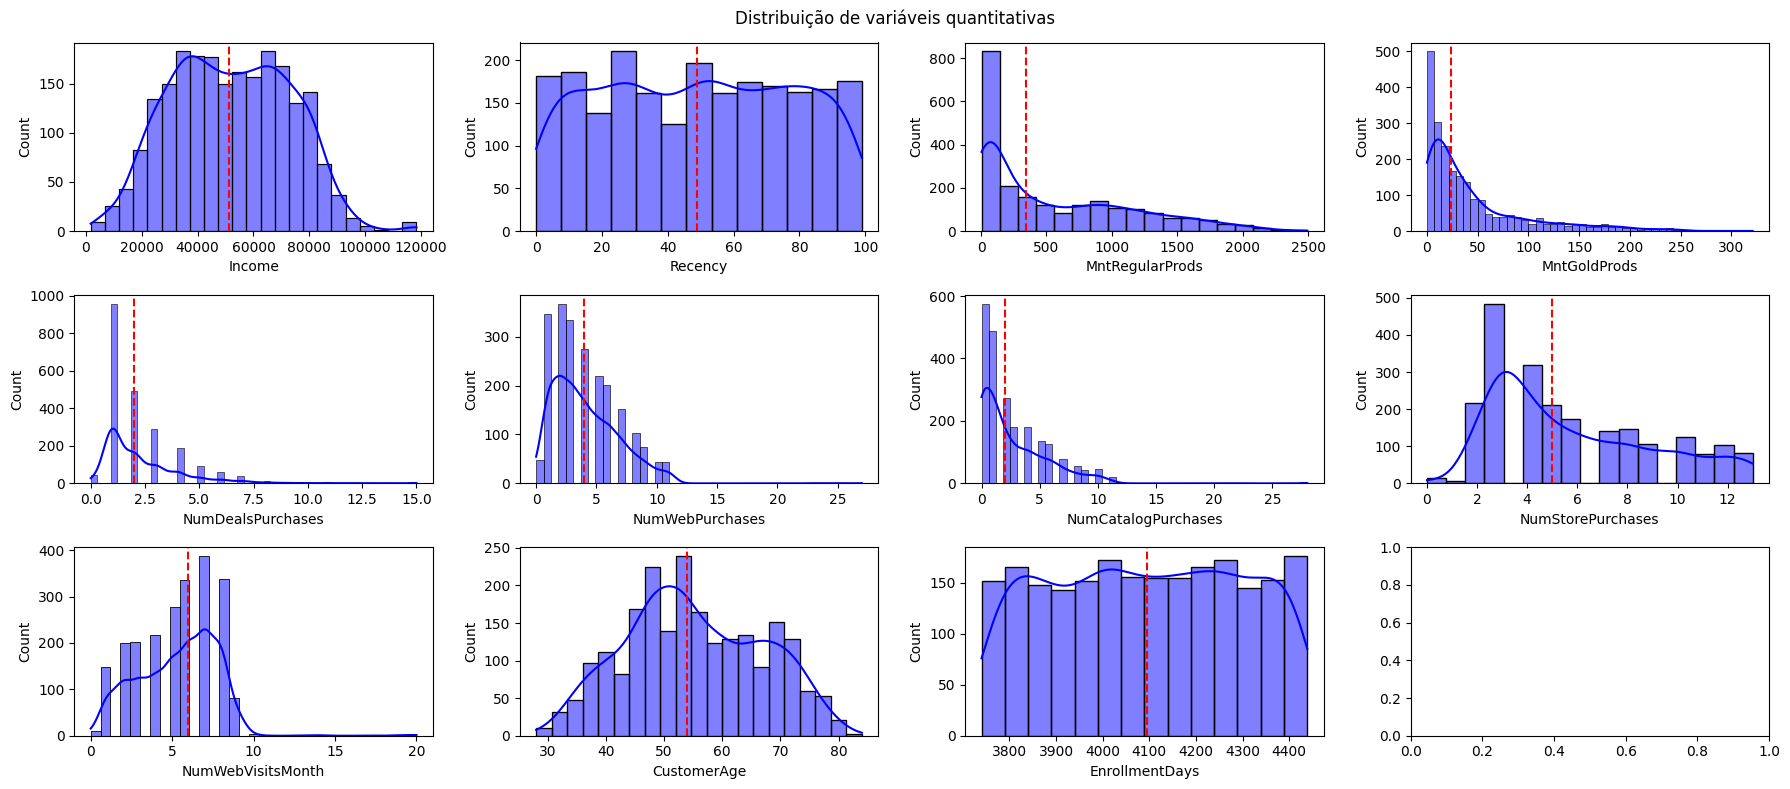

In [939]:
  # Criando histogramas das variáveis quantitativas com a linha da mediana em vermelho
numeric = ifood_df[['Income', 'Recency', 'MntRegularProds', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'CustomerAge', 'EnrollmentDays']]

fig, ax = plt.subplots(3,4, figsize=(18, 8))
ax = ax.flatten()
for i,col in enumerate(numeric.columns):
      sns.histplot(data=ifood_df, x=col,kde=True, ax=ax[i], color='blue')
      ax[i].axvline(ifood_df[col].median(), color='red', linestyle='--')
plt.suptitle('Distribuição de variáveis quantitativas')
plt.tight_layout()
plt.show()


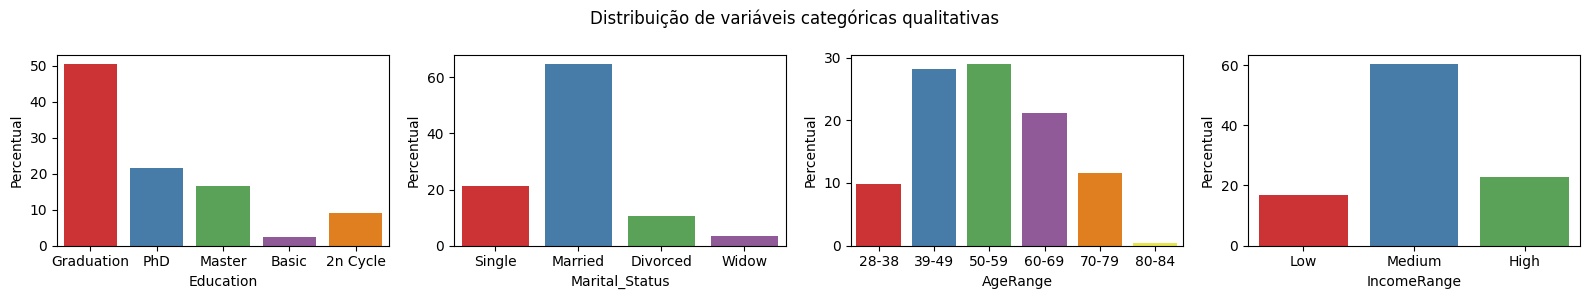

In [940]:
# Criando gráficos das variáveis categóricas qualitativas
sns.set_palette('Set1')
fig, ax = plt.subplots(1,4, figsize=[16,3])
for i, col in enumerate(['Education', 'Marital_Status', 'AgeRange', 'IncomeRange']):
  sns.countplot(data=ifood_df, x=col, ax=ax[i], hue=col, stat='percent', legend=False)
  ax[i].set_ylabel('Percentual')
plt.ylabel('Percentual')
plt.suptitle('Distribuição de variáveis categóricas qualitativas')
plt.tight_layout()
plt.show()


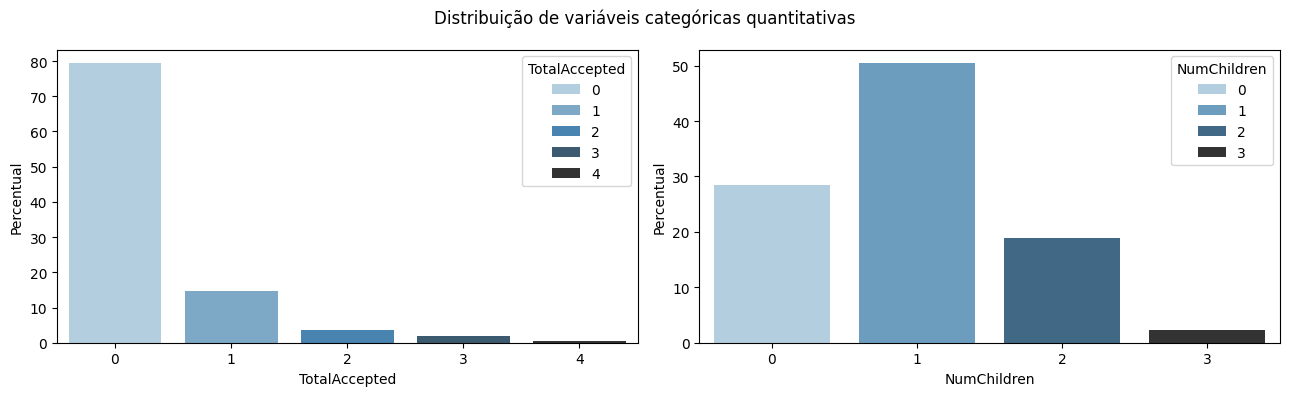

In [941]:
# Criando gráficos das variáveis categóricas quantitativas
fig, ax = plt.subplots(1,2, figsize=[13,4])
for i, col in enumerate(['TotalAccepted', 'NumChildren']):
  sns.countplot(data=ifood_df, x=col, ax=ax[i], hue=col, stat='percent', palette='Blues_d')
  ax[i].set_ylabel('Percentual')
plt.suptitle('Distribuição de variáveis categóricas quantitativas')
plt.tight_layout()
plt.show()

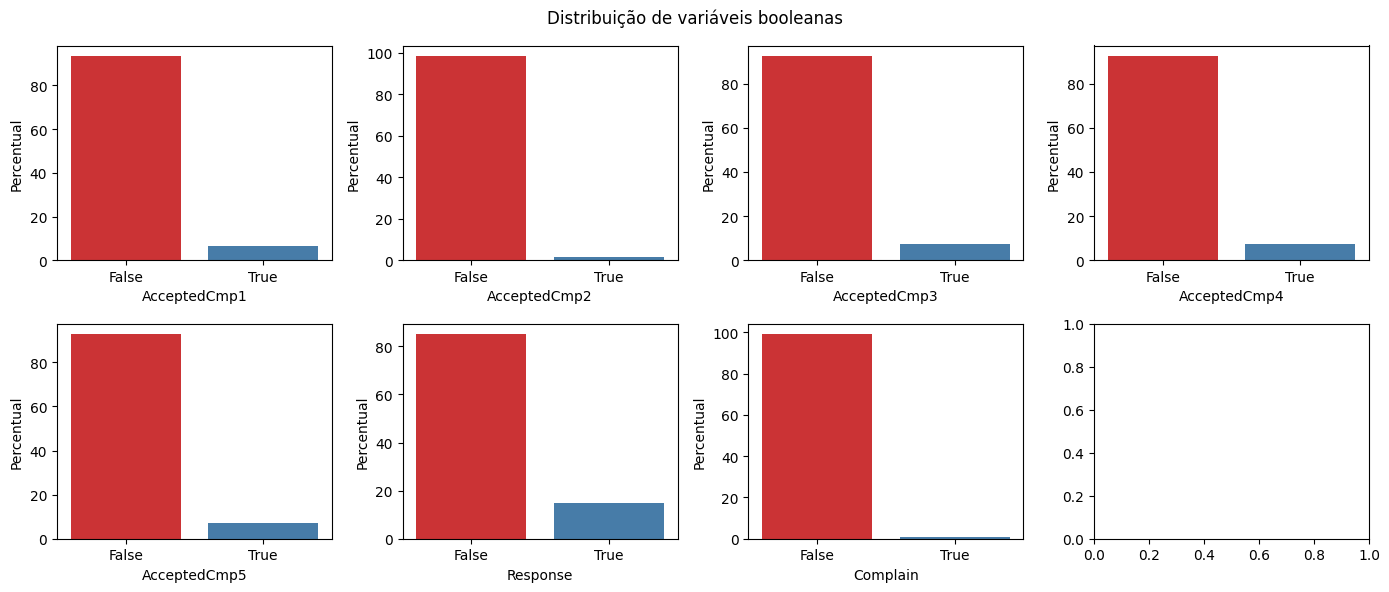

In [942]:
# Criando gráficos das variáveis booleanas

fig, ax = plt.subplots(2,4, figsize=[14,6])
ax = ax.flatten()
for i, col in enumerate(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']):
  sns.countplot(data=ifood_df, x=col, ax=ax[i], hue=col, stat='percent', legend=False, palette='Set1')
  ax[i].set_ylabel('Percentual')
plt.suptitle('Distribuição de variáveis booleanas')


plt.tight_layout()
plt.show()

In [943]:
# Quero ver quanto foi gasto em cada categoria de produtos, separado pelos  diferentes canais de venda.

def calculate_total_spent(df, product_col, channel_col):
  return (df[product_col] * df[channel_col]).sum()

product_cols = ['MntRegularProds', 'MntGoldProds']
channel_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

results = {}

for product_col in product_cols:
  results[product_col] = {}

  for channel_col in channel_cols:
    results[product_col][channel_col] = calculate_total_spent(ifood_df, product_col, channel_col)


spending_by_channel = pd.DataFrame(results).T
spending_by_channel.columns = ['Web', 'Catalog', 'Store']

spending_by_channel

,Web,Catalog,Store
MntRegularProds,6887133,6209577,10000607
MntGoldProds,523068,404126,706228


* Produtos Regulares: maior gasto é direto nas lojas, seguido de compras na web e por último no catálogo
* Produtos Ouro: maior gasto é direto nas lojas, seguido de compras na web e por último no catálogo.

# Segmentando clientes

## Idade


In [944]:
#Criando as tabelas de frequência por faixa de idade

products_melted_age = pd.melt(ifood_df, id_vars=['AgeRange'], value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Products', value_name='Amount Spent')
products_by_age = products_melted_age.groupby(['AgeRange', 'Products'], observed=True)['Amount Spent'].mean().unstack()
products_by_age.columns = ['Regular', 'Ouro']


channels_melted_age = pd.melt(ifood_df, id_vars=['AgeRange'], value_vars=['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], var_name='Channel', value_name='Purchases')
channels_by_age = channels_melted_age.groupby(['AgeRange', 'Channel'], observed=True)['Purchases'].mean().unstack()
channels_by_age.columns = ['Web', 'Catálogo', 'Loja']

campaigns_melted_age = pd.melt(ifood_df, id_vars=['AgeRange'], value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='Campaign', value_name='Accepted')
campaigns_by_age = campaigns_melted_age.groupby(['AgeRange', 'Campaign'], observed=True)['Accepted'].sum().unstack()
campaigns_by_age.columns = ['Cmp 1', 'Cmp 2', 'Cmp 3', 'Cmp 4', 'Cmp 5']

channels_by_age

,Web,Catálogo,Loja
AgeRange,,,
28-38,2.504630,5.532407,3.240741
39-49,2.258842,5.355305,3.774920
50-59,2.456964,5.627543,4.176839
60-69,3.163090,6.358369,4.467811
70-79,3.347656,6.531250,4.585938
80-84,5.875000,7.500000,6.000000


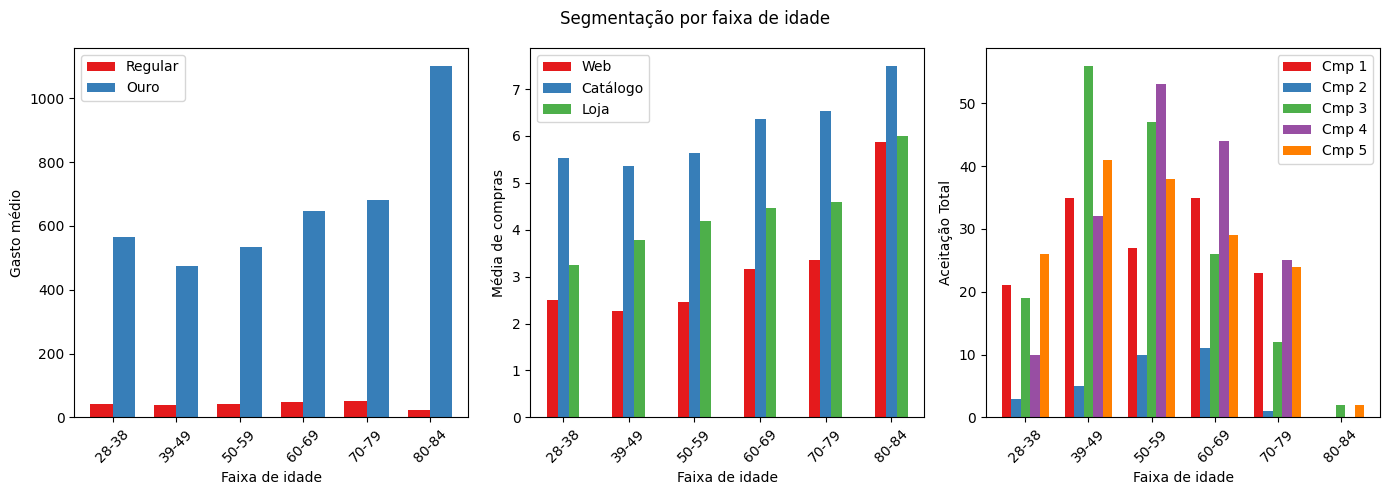

In [945]:
#Função para criar os gráficos mais rapidamente
def plot_age(ylabels=None,*args):
  # Cria uma figura com o gráfico de barras para cada intervalo de idade.
  fig,ax = plt.subplots(1,3, figsize=(14,5))
  df_list = [products_by_age, channels_by_age, campaigns_by_age]
  widths = [0.7, 0.5, 0.75]
  for i, df in enumerate(df_list):
    df_list[i].plot(kind='bar', stacked=False, ax=ax[i], color=custom, width=widths[i])
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlabel('Faixa de idade')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=45)
  plt.suptitle('Segmentação por faixa de idade')
  plt.tight_layout()
  plt.show()
# Gráfico de barras
plot_age(ylabels=['Gasto médio', 'Média de compras', 'Aceitação Total'])

* Clientes mais velhos tendem a gastar mais em produtos ouro, mas não existe nenhuma relação clara de idade com o gasto em produtos regulares;
* O canal de compra segue uma distribuição bem similar em todas as faixas de idade, com as compras em catálogo liderando e as compras na loja logo em seguida;

## Estado Civil

In [946]:
#Criando as tabelas de frequência por estado civil
products_melted_status = pd.melt(ifood_df, id_vars=['Marital_Status'], value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Products', value_name='Amount Spent')
products_melted_status['Marital_Status'] = products_melted_status['Marital_Status'].replace({'Single': 'Solteiro', 'Married': 'Casado', 'Divorced':'Divorciado', 'Widow': 'Viúvo'})
products_by_status = products_melted_status.groupby(['Marital_Status', 'Products'], observed=True)['Amount Spent'].mean().unstack()
products_by_status.columns = ['Regular', 'Ouro']


channels_melted_status = pd.melt(ifood_df, id_vars=['Marital_Status'], value_vars=['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], var_name='Channel', value_name='Purchases')
channels_melted_status['Marital_Status'] = channels_melted_status['Marital_Status'].replace({'Single': 'Solteiro', 'Married': 'Casado', 'Divorced':'Divorciado', 'Widow': 'Viúvo'})
channels_by_status = channels_melted_status.groupby(['Marital_Status', 'Channel'], observed=True)['Purchases'].mean().unstack()
channels_by_status.columns = ['Web', 'Catálogo', 'Loja']


campaigns_melted_status = pd.melt(ifood_df, id_vars=['Marital_Status'], value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='Campaign', value_name='Accepted')
campaigns_melted_status['Marital_Status'] = campaigns_melted_status['Marital_Status'].replace({'Single': 'Solteiro', 'Married': 'Casado', 'Divorced':'Divorciado', 'Widow': 'Viúvo'})
campaigns_by_status = campaigns_melted_status.groupby(['Marital_Status', 'Campaign'], observed=True)['Accepted'].sum().unstack()
campaigns_by_status.columns = ['Cmp 1', 'Cmp 2', 'Cmp 3', 'Cmp 4', 'Cmp 5']



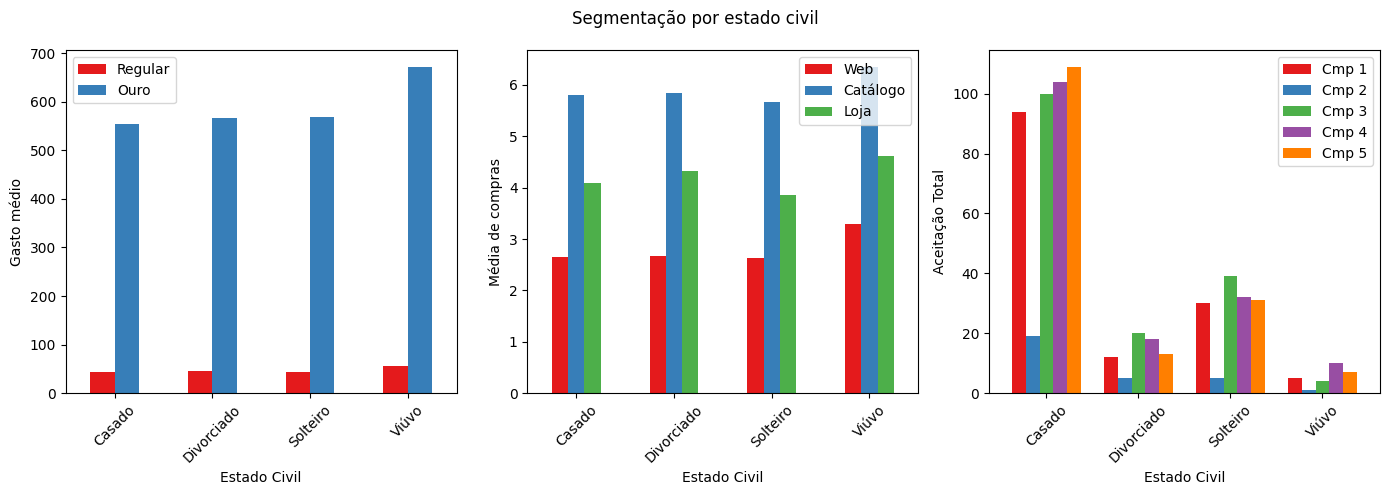

In [947]:
def plot_marital_status(ylabels=None,*args):
  # Cria uma figura com o gráfico de barras para cada estado civil.
  fig,ax = plt.subplots(1,3, figsize=(14,5))
  df_list = [products_by_status, channels_by_status, campaigns_by_status]
  widths = [0.5, 0.5, 0.75]
  for i, df in enumerate(df_list):
    df_list[i].plot(kind='bar', stacked=False, ax=ax[i], color=custom, width=widths[i])
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlabel('Estado Civil')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=45)
  plt.suptitle('Segmentação por estado civil')
  plt.tight_layout()
  plt.show()

plot_marital_status(ylabels=['Gasto médio', 'Média de compras', 'Aceitação Total'])

* Clientes casados foram os que mais aceitaram campanhas no geral, e os que mais aceitaram a campanhas 5;
* A campanhas 3 foi a mais aceita entre clientes solteiros e divorciados;
* A campanha 4 foi a mais aceita por clientes viúvos.

## Escolaridade

In [948]:
#Criando as tabelas de frequência por escolaridade
products_melted_education = pd.melt(ifood_df, id_vars=['Education'], value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Products', value_name='Amount Spent')
products_melted_education['Education'] = products_melted_education['Education'].replace({'Graduation':'Graduação', 'Master': 'Mestrado', '2n Cycle':'Ensino Médio', 'Basic': 'Fundamental'})
products_by_education = products_melted_education.groupby(['Education', 'Products'], observed=True)['Amount Spent'].mean().unstack()
products_by_education.columns = ['Regular', 'Ouro']


channels_melted_education = pd.melt(ifood_df, id_vars=['Education'], value_vars=['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], var_name='Channel', value_name='Purchases')
channels_melted_education['Education'] = channels_melted_education['Education'].replace({'Graduation':'Graduação', 'Master': 'Mestrado', '2n Cycle':'Ensino Médio', 'Basic': 'Fundamental'})
channels_by_education = channels_melted_education.groupby(['Education', 'Channel'], observed=True)['Purchases'].mean().unstack()
channels_by_education.columns = ['Web', 'Catálogo', 'Loja']


campaigns_melted_education = pd.melt(ifood_df, id_vars=['Education'], value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='Campaign', value_name='Accepted')
campaigns_melted_education['Education'] = campaigns_melted_education['Education'].replace({'Graduation':'Graduação', 'Master': 'Mestrado', '2n Cycle':'Ensino Médio', 'Basic': 'Fundamental'})
campaigns_by_education = campaigns_melted_education.groupby(['Education', 'Campaign'], observed=True)['Accepted'].sum().unstack()
campaigns_by_education.columns = ['Cmp 1', 'Cmp 2', 'Cmp 3', 'Cmp 4', 'Cmp 5']



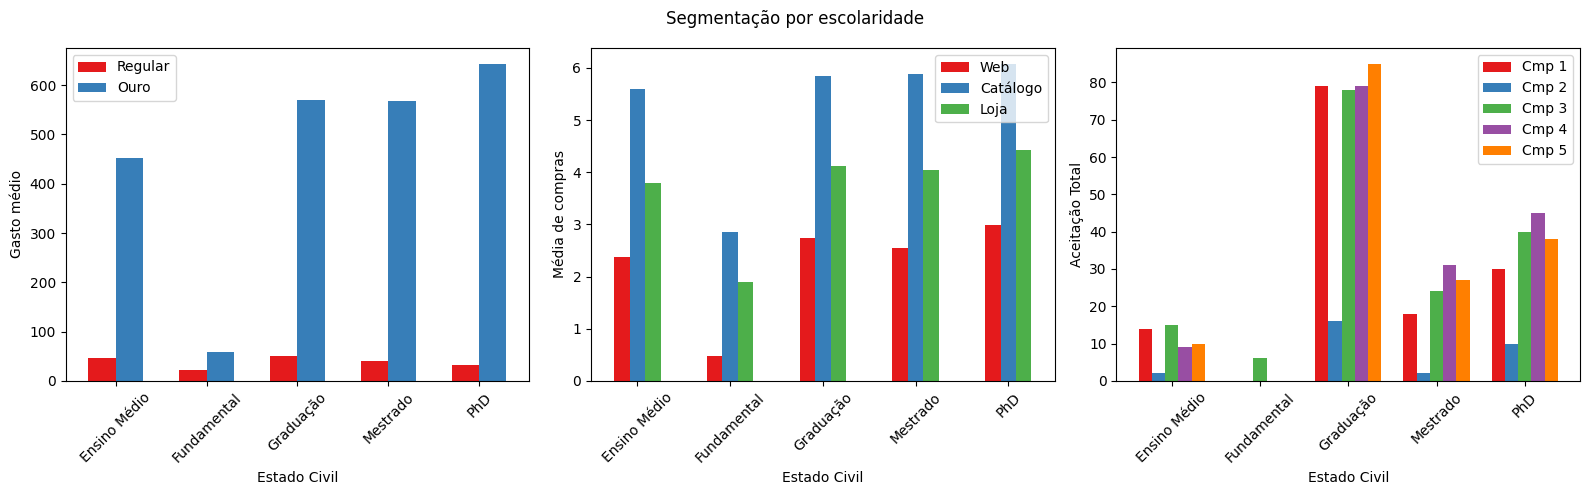

In [949]:
def plot_education(ylabels=None,*args):
  # Cria uma figura com o gráfico de barras para cada estado civil.
  fig,ax = plt.subplots(1,3, figsize=(16,5))
  df_list = [products_by_education, channels_by_education, campaigns_by_education]
  widths = [0.6, 0.5, 0.75]
  for i, df in enumerate(df_list):
    df_list[i].plot(kind='bar', stacked=False, ax=ax[i], color=custom, width=widths[i])
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlabel('Estado Civil')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=45)
  plt.suptitle('Segmentação por escolaridade')
  plt.tight_layout()
  plt.show()

plot_education(ylabels=['Gasto médio', 'Média de compras', 'Aceitação Total'])

* Clientes que possuem apenas o ensino fundamental possuem uma média baixa de compras ouro e também são os que menos aceitaram campanhas.
* Graduados são os que mais aceitaram campanhas no geral, com a campanha 5 tendo a maior aceitação e a campanha 2 tendo a menor

## Quantidade de filhos

In [950]:
#Criando as tabelas de frequência por quantidade de filhos
products_melted_children = pd.melt(ifood_df, id_vars=['NumChildren'], value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Products', value_name='Amount Spent')
products_by_children = products_melted_children.groupby(['NumChildren', 'Products'], observed=True)['Amount Spent'].mean().unstack()
products_by_children.columns = ['Regular', 'Ouro']

channels_melted_children = pd.melt(ifood_df, id_vars=['NumChildren'], value_vars=['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], var_name='Channel', value_name='Purchases')
channels_by_children = channels_melted_children.groupby(['NumChildren', 'Channel'], observed=True)['Purchases'].mean().unstack()
channels_by_children.columns = ['Web', 'Catálogo', 'Loja']


campaigns_melted_children = pd.melt(ifood_df, id_vars=['NumChildren'], value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='Campaign', value_name='Accepted')
campaigns_by_children = campaigns_melted_children.groupby(['NumChildren', 'Campaign'], observed=True)['Accepted'].sum().unstack()
campaigns_by_children.columns = ['Cmp 1', 'Cmp 2', 'Cmp 3', 'Cmp 4', 'Cmp 5']


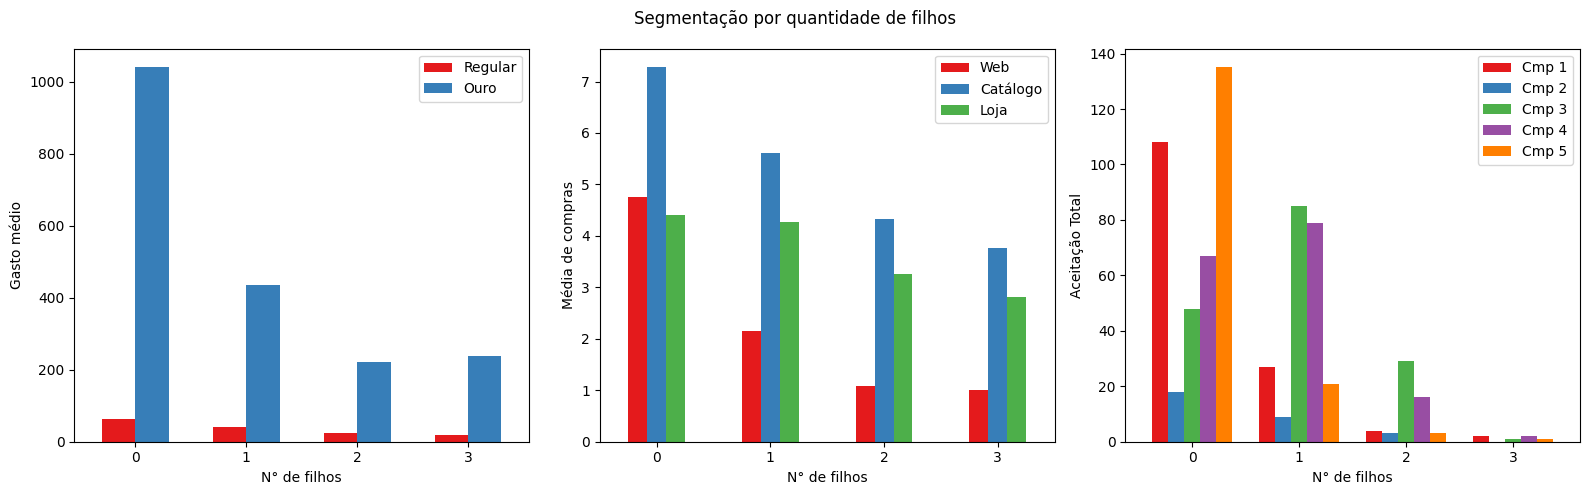

In [951]:
custom = sns.color_palette("Set1")
def plot_children(ylabels=None,*args):
  # Cria uma figura com o gráfico de barras para cada estado civil.
  fig,ax = plt.subplots(1,3, figsize=(16,5))
  df_list = [products_by_children, channels_by_children, campaigns_by_children]
  widths = [0.6, 0.5, 0.75]
  for i, df in enumerate(df_list):
    df_list[i].plot(kind='bar', stacked=False, ax=ax[i], color=custom, width=widths[i])
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlabel('N° de filhos')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=0)
  plt.suptitle('Segmentação por quantidade de filhos')
  plt.tight_layout()
  plt.show()

plot_children(ylabels=['Gasto médio', 'Média de compras', 'Aceitação Total'])

* Pessoas com menos filhos tendem a aceitar mais campanhas;


## Salário anual

In [952]:
# Criando as novas colunas
salaries = ifood_df.copy()
salaries['high_income'] = ifood_df['Income'] >= 70000
salaries['medium_income'] = (ifood_df['Income'] > 30000) & (ifood_df['Income'] < 70000)
salaries['low_income'] = ifood_df['Income'] <= 30000

In [953]:
def high_income_melt(value_vars, var_name, value_name):
  # Cria uma tabela em que 'high_income' é o ID com tipo de produto e valor como colunas
  melted = pd.melt(salaries, id_vars=['high_income'], value_vars=value_vars, var_name=var_name, value_name=value_name)
  return melted[melted['high_income'] == True]

def medium_income_melt(value_vars, var_name, value_name):
 # Cria uma tabela em que 'medium_income' é o ID com tipo de produto e valor como colunas
  melted = pd.melt(salaries, id_vars=['medium_income'], value_vars=value_vars, var_name=var_name, value_name=value_name)
  return melted[melted['medium_income'] == True]

def low_income_melt(value_vars, var_name, value_name):
 # Cria uma tabela em que 'low_income' é o ID com tipo de produto e valor como colunas
  melted = pd.melt(salaries, id_vars=['low_income'], value_vars=value_vars, var_name=var_name, value_name=value_name)
  return melted[melted['low_income'] == True]


def plot_income(x_col, y_col, df_list, hue_col, *args, **kwargs):
  # Cria uma figura com o gráfico de barras de cada intervalo salarial.
  fig, ax = plt.subplots(1,3, **kwargs, sharey=True)
  titles = ['Classe Alta', 'Classe Média', 'Classe Baixa']
  for i, df in enumerate(df_list):
    total = df[y_col].sum()
    sns.barplot(x=x_col, y=y_col, data=df, hue=hue_col, ax=ax[i], estimator=sum, palette='Set1')
    ax[i].set_title(titles[i])

  plt.suptitle(*args)
  plt.tight_layout()
  plt.show()

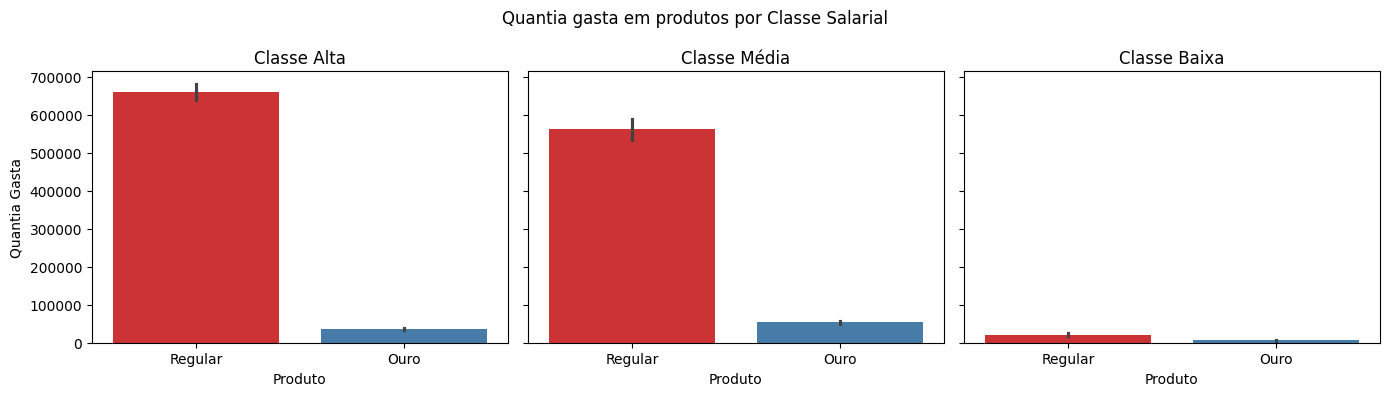

In [954]:
# Separando as classes de salário por quantidade gasta em cada produto
high_income_mnt = high_income_melt(value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Produto', value_name='Quantia Gasta')
medium_income_mnt = medium_income_melt(value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Produto', value_name='Quantia Gasta')
low_income_mnt = low_income_melt(value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Produto', value_name='Quantia Gasta')

#Mudando o nome das variáveis
high_income_mnt['Produto'] = high_income_mnt['Produto'].replace({'MntRegularProds': 'Regular', 'MntGoldProds': 'Ouro'})
medium_income_mnt['Produto'] = medium_income_mnt['Produto'].replace({'MntRegularProds': 'Regular', 'MntGoldProds': 'Ouro'})
low_income_mnt['Produto'] = low_income_mnt['Produto'].replace({'MntRegularProds': 'Regular', 'MntGoldProds': 'Ouro'})

plot_income('Produto', 'Quantia Gasta', [high_income_mnt, medium_income_mnt, low_income_mnt], 'Produto', 'Quantia gasta em produtos por Classe Salarial', figsize=(14,4))

Como esperado, os clientes que ganham mais também gastam mais. Porém, os clientes de salário médio são os que gastam mais com produtos ouro.

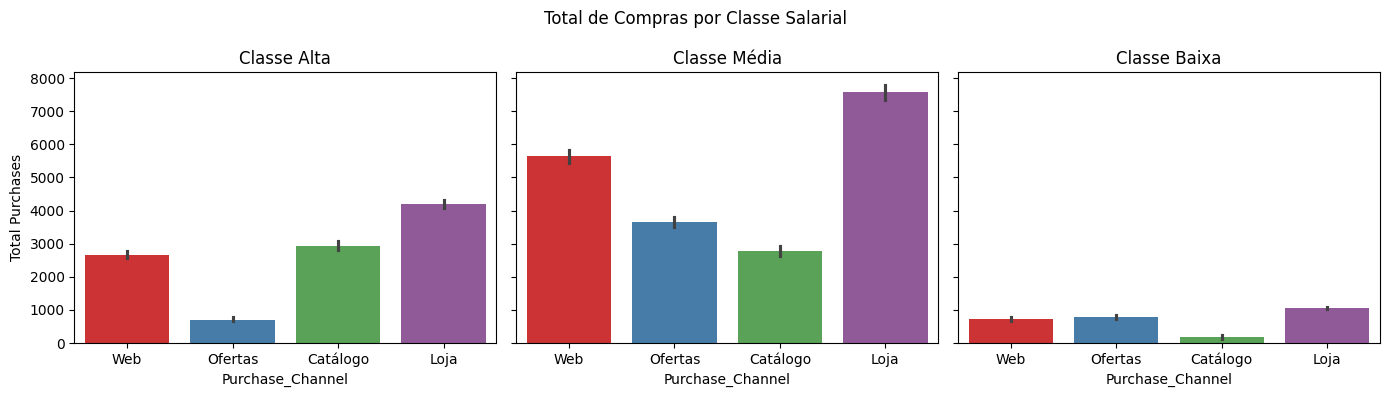

In [955]:
# Separando as classes de salário por canal de compra
high_income_purchases = high_income_melt(value_vars=['NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], var_name='Purchase_Channel', value_name='Total Purchases')
medium_income_purchases = medium_income_melt(value_vars=['NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], var_name='Purchase_Channel', value_name='Total Purchases')
low_income_purchases = low_income_melt(value_vars=['NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], var_name='Purchase_Channel', value_name='Total Purchases')
#Mudando o nome das variáveis
high_income_purchases['Purchase_Channel'] = high_income_purchases['Purchase_Channel'].replace({'NumWebPurchases':'Web', 'NumDealsPurchases': 'Ofertas', 'NumCatalogPurchases':'Catálogo', 'NumStorePurchases':'Loja'})
medium_income_purchases['Purchase_Channel'] = medium_income_purchases['Purchase_Channel'].replace({'NumWebPurchases':'Web', 'NumDealsPurchases': 'Ofertas', 'NumCatalogPurchases':'Catálogo', 'NumStorePurchases':'Loja'})
low_income_purchases['Purchase_Channel'] = low_income_purchases['Purchase_Channel'].replace({'NumWebPurchases':'Web', 'NumDealsPurchases': 'Ofertas', 'NumCatalogPurchases':'Catálogo', 'NumStorePurchases':'Loja'})

plot_income('Purchase_Channel', 'Total Purchases', [high_income_purchases, medium_income_purchases, low_income_purchases], 'Purchase_Channel', 'Total de Compras por Classe Salarial', figsize=(14,4))


Clientes com salários maiores são os que menos compram com desconto, seguido dos clientes com salários baixos, enquanto clientes de salários médios são os que mais compram com desconto.

Referente aos locais de compra, todos fazem mais compras pelas lojas.

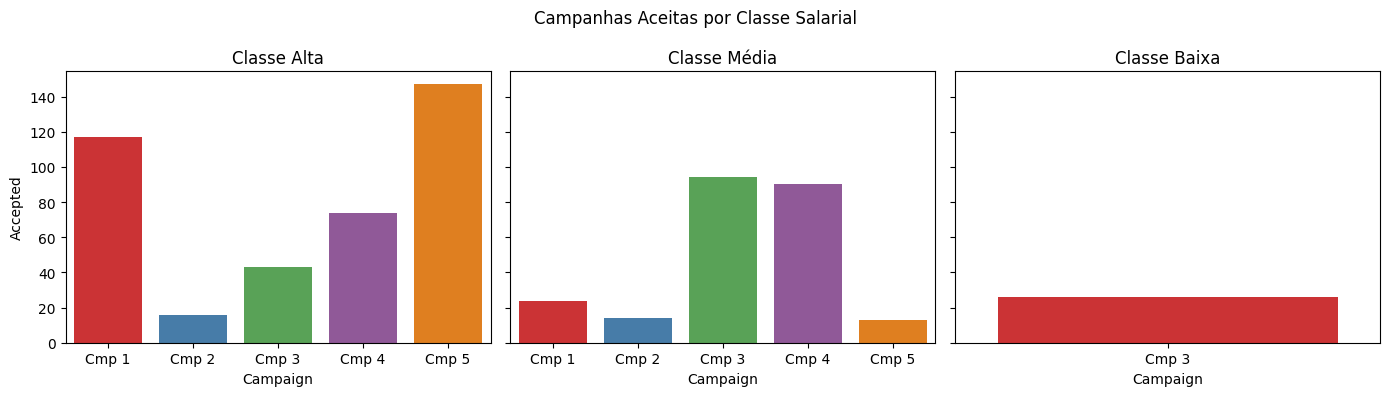

In [956]:
# Separando as classes de salário por aceitação de campanhas
high_income_acceptance = high_income_melt(value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='Campaign', value_name='Accepted')
medium_income_acceptance = medium_income_melt(value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='Campaign', value_name='Accepted')
low_income_acceptance = low_income_melt(value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='Campaign', value_name='Accepted')
#Mudando o nome das variáveis
high_income_acceptance['Campaign'] = high_income_acceptance['Campaign'].replace({'AcceptedCmp1': 'Cmp 1', 'AcceptedCmp2': 'Cmp 2', 'AcceptedCmp3': 'Cmp 3', 'AcceptedCmp4': 'Cmp 4', 'AcceptedCmp5': 'Cmp 5'})
medium_income_acceptance['Campaign'] = medium_income_acceptance['Campaign'].replace({'AcceptedCmp1': 'Cmp 1', 'AcceptedCmp2': 'Cmp 2', 'AcceptedCmp3': 'Cmp 3', 'AcceptedCmp4': 'Cmp 4', 'AcceptedCmp5': 'Cmp 5'})
low_income_acceptance['Campaign'] = low_income_acceptance['Campaign'].replace({'AcceptedCmp1': 'Cmp 1', 'AcceptedCmp2': 'Cmp 2', 'AcceptedCmp3': 'Cmp 3', 'AcceptedCmp4': 'Cmp 4', 'AcceptedCmp5': 'Cmp 5'})

# Filtrando somente as campanhas aceitas
high_income_acceptance = high_income_acceptance[high_income_acceptance['Accepted'] == True]
medium_income_acceptance = medium_income_acceptance[medium_income_acceptance['Accepted'] == True]
low_income_acceptance = low_income_acceptance[low_income_acceptance['Accepted'] == True]

plot_income('Campaign', 'Accepted', [high_income_acceptance, medium_income_acceptance, low_income_acceptance], 'Campaign', 'Campanhas Aceitas por Classe Salarial', figsize=(14,4))

* A campanha 5 foi a mais aceita por clientes da classe alta;
* A campanha 3 foi a mais aceita por clientes da classe média;
* Os clientes da classe baixa aceitaram somente a campanha 3.

In [957]:
#Qual foi a campanha mais aceita?
ifood_df['TotalAccepted'].value_counts()

,count
TotalAccepted,
0,1752
1,322
2,80
3,44
4,11


## Criando perfil de clientes
* Clientes Gold: gastam com produtos caros
* Clientes VIP: gastam mais no geral
* Clientes fiéis: aceitaram mais campanhas

In [958]:
# Criando uma coluna com o total de vendas
ifood_df['MntOverallProds'] = ifood_df[['MntRegularProds', 'MntGoldProds']].sum(axis=1)
#Segmentando os clientes
vip_customers = ifood_df[ifood_df['MntOverallProds'] > 2200].copy()
gold_customers = ifood_df[ifood_df['MntGoldProds'] > 200]
faithful_customers = ifood_df[ifood_df['TotalAccepted'] > 2]


In [959]:
rv = []
for col in ['Marital_Status', 'IncomeRange', 'AgeRange', 'NumChildren', 'Education', 'EnrollmentDays']:
  vips = vip_customers[col].value_counts().index[0]
  rv.append(str((vips)))

rg = []
for col in ['Marital_Status', 'IncomeRange', 'AgeRange', 'NumChildren', 'Education', 'EnrollmentDays']:
  golds = gold_customers[col].value_counts().index[0]
  rg.append(str((golds)))

rf = []
for col in ['Marital_Status', 'IncomeRange', 'AgeRange', 'NumChildren', 'Education', 'EnrollmentDays']:
  fi = faithful_customers[col].value_counts().index[0]
  rf.append(str((fi)))

print(f'CLIENTE VIP: {", ".join(rv)}')
print(f'CLIENTE GOLD: {", ".join(rg)}')
print(f'CLIENTE FIEL: {", ".join(rf)}')



CLIENTE VIP: Married, High, 70-79, 0, Graduation, 4222
CLIENTE GOLD: Married, High, 39-49, 0, Graduation, 3778
CLIENTE FIEL: Married, High, 39-49, 0, Graduation, 4145


## Verificando quem aceitou a última campanha

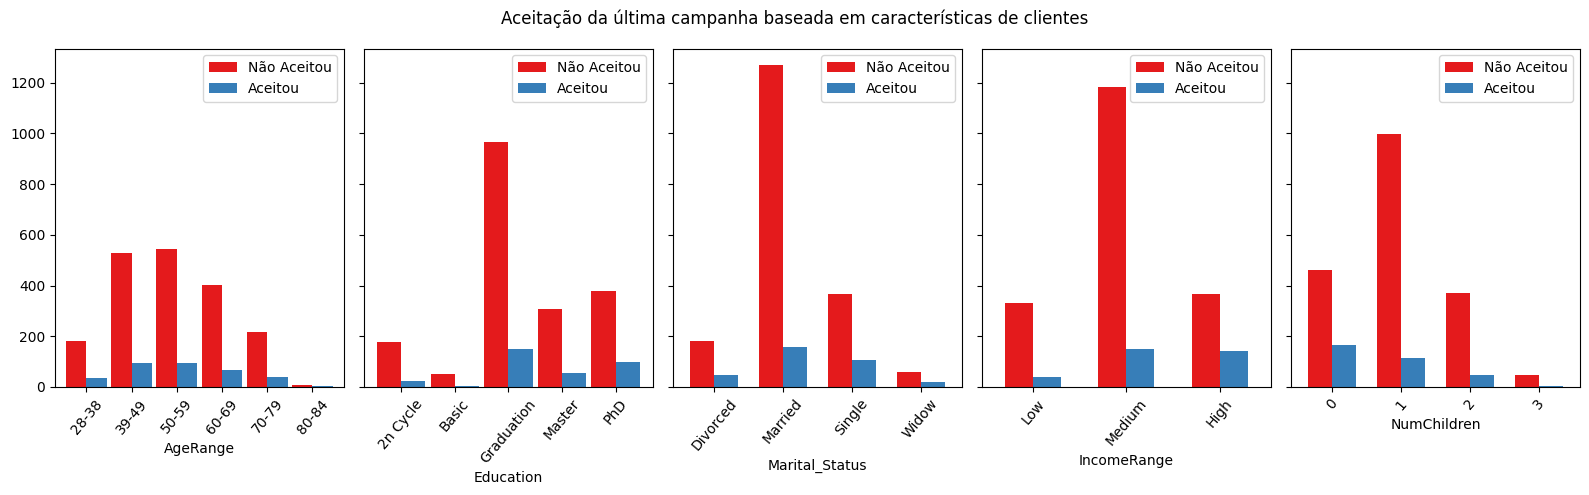

In [960]:
age_response = pd.crosstab(ifood_df['AgeRange'], ifood_df['Response'])
edu_response = pd.crosstab(ifood_df['Education'], ifood_df['Response'])
marital_response = pd.crosstab(ifood_df['Marital_Status'], ifood_df['Response'])
income_response = pd.crosstab(ifood_df['IncomeRange'], ifood_df['Response'])
children_response = pd.crosstab(ifood_df['NumChildren'], ifood_df['Response'])

#Mudando nomes pra melhor compreensão
age_response.columns = ['Não Aceitou', 'Aceitou']
edu_response.columns = ['Não Aceitou', 'Aceitou']
marital_response.columns = ['Não Aceitou', 'Aceitou']
income_response.columns = ['Não Aceitou', 'Aceitou']
children_response.columns = ['Não Aceitou', 'Aceitou']

fig, ax = plt.subplots(1,5, figsize=(16,5), sharey=True)
widths = [0.9, 0.9, 0.7, 0.6, 0.7]
for i, df in enumerate([age_response, edu_response, marital_response, income_response, children_response]):
  df.plot(kind='bar', stacked=False, ax=ax[i], color=custom, width=widths[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=50)
  ax[i].set_xlabel(df.index.name)
plt.suptitle('Aceitação da última campanha baseada em características de clientes')
plt.tight_layout()
plt.show()



In [961]:
# Qual o perfil de cliente que aceitou a última campanha?
accepted_last_cmp = ifood_df[ifood_df['Response'] == True]
resp = []

for col in ['Marital_Status', 'IncomeRange', 'AgeRange', 'NumChildren', 'Education', 'EnrollmentDays']:
  accepted = accepted_last_cmp[col].value_counts().index[0]
  resp.append(str((accepted)))

print(f'Aceitou última campanha: {", ".join(resp)}')

Aceitou última campanha: Married, Medium, 39-49, 0, Graduation, 4337


# Modelo de classificação para prever próximas campanhas

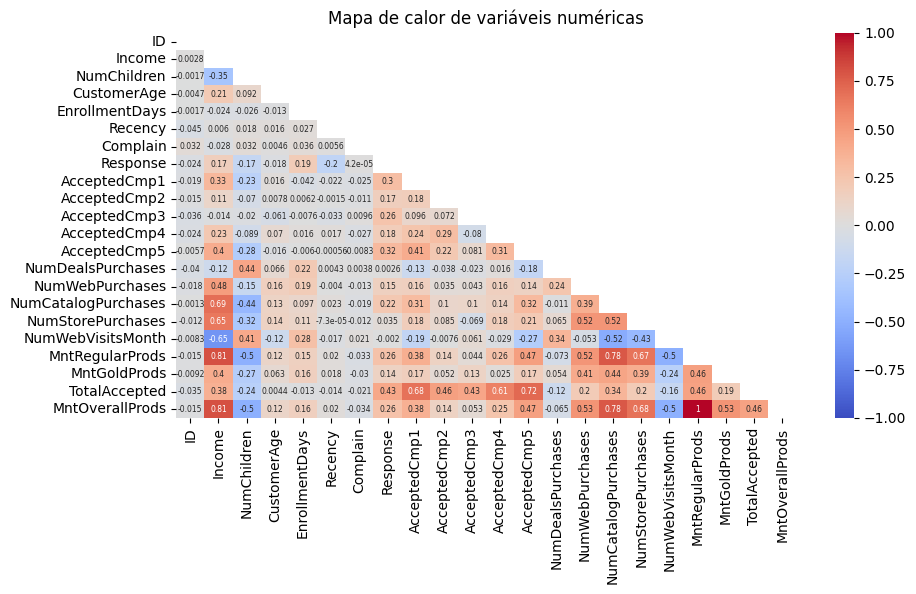

<Figure size 1000x500 with 0 Axes>

In [962]:
mask = np.triu(np.ones_like(ifood_df.corr(numeric_only=True)))
plt.figure(figsize=(10, 5))
sns.heatmap(ifood_df.corr(numeric_only=True), cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, mask=mask, annot_kws={'size': 5.5})
plt.title("Mapa de calor de variáveis numéricas")
plt.figure(figsize=(10, 5))
plt.show()

No geral, as únicas correlações relevantes (acima de 0.7) são entre Produtos Regulares x Compras no catálogo e Produtos Regulares x Salário anual.
É interessante notar que o número de visitas ao site não correlaciona com compras pelo mesmo. Seria interessante olhar isso mais a fundo, monitorar os cliques em certas propagandas e criar métricas de conversão para vendas.
No momento, vamos verificar sobre as variáveis que se relacionam.

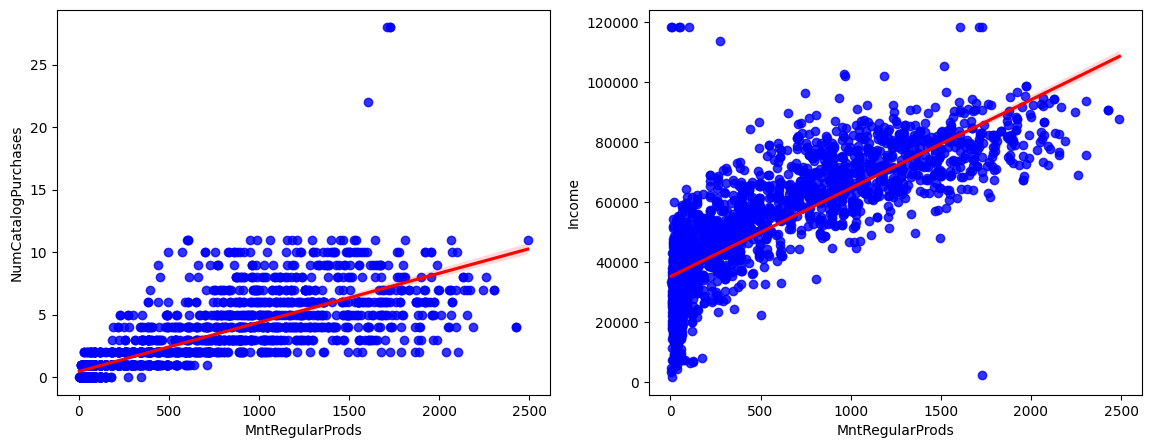

In [963]:
#
fig, ax = plt.subplots(1,2, figsize=(14,5))
for i, col in enumerate(['NumCatalogPurchases', 'Income']):
  sns.regplot(data=ifood_df, y=col, x='MntRegularProds', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, ax=ax[i])


A tendência é que clientes com salários maiores gastem mais com produtos regulares e que clientes em geral comprem esses produtos mais em catálogos.

Será que clientes com mais tempo tem maiorprobabilidade de aceitar a campanha?

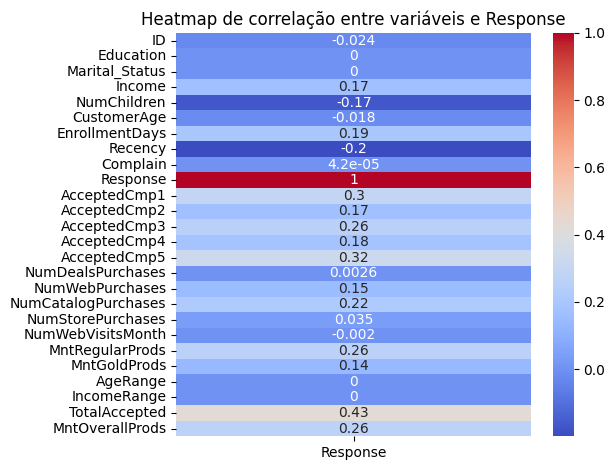

In [964]:
from scipy import stats

# Convert boolean column to numeric
ifood_df['ResponseNum'] = ifood_df['Response'].astype(int)

# Calculate point-biserial correlation for numeric columns only
correlations = ifood_df.apply(lambda x: stats.pointbiserialr(ifood_df['ResponseNum'], x)[0] if pd.api.types.is_numeric_dtype(x) else 0)

# Remove 'ResponseNum' column
correlations = correlations.drop('ResponseNum')

# Plot heatmap
sns.heatmap(correlations.values.reshape(-1,1), annot=True, cmap='coolwarm', xticklabels=['Response'], yticklabels=correlations.index)
plt.title('Heatmap de correlação entre variáveis e Response')
plt.tight_layout()
plt.show()